<a href="https://colab.research.google.com/github/afrojaakter/Surrogate-Based-Optimization/blob/main/GaussianProcessClassifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
except:
    pass

--2021-08-13 22:31:38--  https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3842 (3.8K) [text/plain]
Saving to: ‘gaussian_processes_util.py’

gaussian_processes_ 100%[===================>]   3.75K  --.-KB/s    in 0s      

2021-08-13 22:31:38 (51.9 MB/s) - ‘gaussian_processes_util.py’ saved [3842/3842]



In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import bernoulli
from scipy.special import expit as sigmoid

from sklearn.datasets import make_moons
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from gaussian_processes_util import (
    plot_data_1D,
    plot_data_2D,
    plot_pt_2D,
    plot_db_2D)

%matplotlib inline



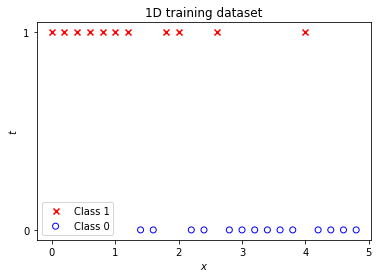

In [61]:
# 1D dataset
np.random.seed(0)

X = np.arange(0, 5, 0.2).reshape(-1, 1)
X_test = np.arange(-2, 7, 0.1).reshape(-1, 1)

a = np.cos(X * np.pi * 0.25) * 2
t = bernoulli.rvs(sigmoid(a))

plot_data_1D(X, t)
plt.title('1D training dataset')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.yticks([0, 1])
plt.legend();

In [49]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """

    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return theta[1] ** 2 * np.exp(-0.5 / theta[0] ** 2 * sqdist)

In [50]:
def K_(X, theta, diag_only=False, nu=1e-5):
    """Helper to apply kernel function."""
    if diag_only:
        # Specific solution for isotropic 
        # squared exponential kernel.
        return theta[1] ** 2 + nu
    else:
        return kernel(X, X, theta) + nu * np.eye(X.shape[0])

def W_(a):
    """Helper to compute matrix W."""
    r = sigmoid(a) * (1 - sigmoid(a))
    return np.diag(r.ravel())

In [51]:
def posterior_mode(X, t, K_a, max_iter=10, tol=1e-9):
    """
    Computes the mode of posterior p(a|t).
    """
    a_h = np.zeros_like(t)
    I = np.eye(X.shape[0])

    for i in range(max_iter):
        W = W_(a_h)
        Q_inv = np.linalg.inv(I + W @ K_a)
        a_h_new = (K_a @ Q_inv).dot(t - sigmoid(a_h) + W.dot(a_h))
        a_h_diff = np.abs(a_h_new - a_h)
        a_h = a_h_new

        if not np.any(a_h_diff > tol):
            break

    return a_h

In [52]:
def nll_fn(X, t):
    """
    Returns the negative log-likelihood function for data X, t.
    """
    
    t = t.ravel()

    def nll(theta):
        K_a = K_(X, theta)
        K_a_inv = np.linalg.inv(K_a)

        # posterior mode depends on theta (via K)
        a_h = posterior_mode(X, t, K_a).ravel()
        W = W_(a_h)

        ll = - 0.5 * a_h.T.dot(K_a_inv).dot(a_h) \
             - 0.5 * np.linalg.slogdet(K_a)[1] \
             - 0.5 * np.linalg.slogdet(W + K_a_inv)[1] \
             + t.dot(a_h) - np.sum(np.log(1.0 + np.exp(a_h)))

        return -ll

    return nll

In [63]:
res = minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')


Optimized theta = [2.124, 2.265], negative log likelihood = 14.253


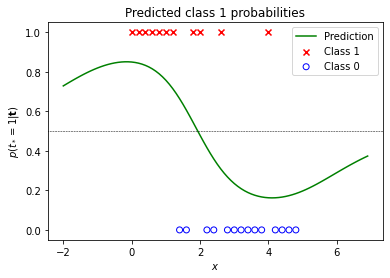

In [64]:
def predict_a(X_test, X, t, theta):
    """
    Computes the mean and variance of logits at points X_test
    given training data X, t and kernel parameters theta.
    """
    K_a = K_(X, theta)
    K_s = kernel(X, X_test, theta)
    a_h = posterior_mode(X, t, K_a)

    W_inv = np.linalg.inv(W_(a_h))
    R_inv = np.linalg.inv(W_inv + K_a)

    a_test_mu = K_s.T.dot(t - sigmoid(a_h))
    # Compute variances only (= diagonal) instead of full covariance matrix
    a_test_var = K_(X_test, theta, diag_only=True) - np.sum((R_inv @ K_s) * K_s, axis=0).reshape(-1, 1)

    return a_test_mu, a_test_var


def predict_pt(X_test, X, t, theta):
    """
    Computes the probability of t=1 at points X_test
    given training data X, t and kernel parameters theta.
    """
    a_mu, a_var = predict_a(X_test, X, t, theta)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * a_var / 8)
    return sigmoid(kappa * a_mu)


pt_test = predict_pt(X_test, X, t, theta)

plot_data_1D(X, t)
plt.plot(X_test, pt_test, label='Prediction', color='green')
plt.axhline(0.5, X_test.min(), X_test.max(), color='black', ls='--', lw=0.5)
plt.title('Predicted class 1 probabilities')
plt.xlabel('$x$')
plt.ylabel('$p(t_*=1|\mathbf{t})$')
plt.legend();

Optimized theta = [2.124, 2.261], negative log likelihood = 14.253


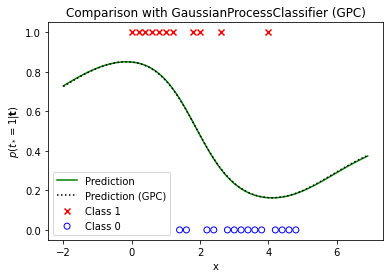

In [65]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, t.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

sklearn_theta_0, sklearn_theta_1, -gpc.log_marginal_likelihood_value_
print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

pt_test_gpc = gpc.predict_proba(X_test.reshape(-1, 1))[:,1]

plot_data_1D(X, t)
plt.plot(X_test, pt_test, label='Prediction', color='green')
plt.plot(X_test, pt_test_gpc, label='Prediction (GPC)', color='black', ls=':')
plt.title('Comparison with GaussianProcessClassifier (GPC)')
plt.xlabel('x')
plt.ylabel('$p(t_*=1|\mathbf{t})$')
plt.legend();

###2D example

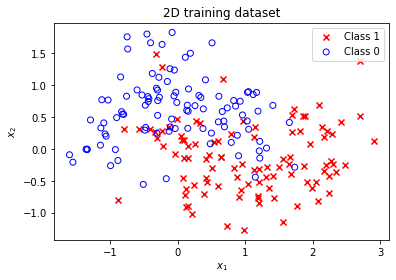

In [41]:
X, t = make_moons(200, noise=.4, random_state=2)
t = t.reshape(-1, 1)

plot_data_2D(X, t)
plt.title('2D training dataset')
plt.legend();

In [42]:
res = minimize(nll_fn(X, t), [1, 1],
               bounds=((1e-3, None), (1e-3, None)),
               method='L-BFGS-B')

theta = res.x

print(f'Optimized theta = [{theta[0]:.3f}, {theta[1]:.3f}], negative log likelihood = {res.fun:.3f}')

Optimized theta = [0.985, 3.329], negative log likelihood = 82.544


In [43]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=rbf)

gpc.fit(X, t.ravel())

# Obtain optimized kernel parameters
sklearn_theta_0 = gpc.kernel_.k2.get_params()['length_scale']
sklearn_theta_1 = np.sqrt(gpc.kernel_.k1.get_params()['constant_value'])

print(f'Optimized theta = [{sklearn_theta_0:.3f}, {sklearn_theta_1:.3f}], negative log likelihood = {-gpc.log_marginal_likelihood_value_:.3f}')

Optimized theta = [1.003, 3.404], negative log likelihood = 82.541


In [44]:
grid_x, grid_y = np.mgrid[-4:4:200j, -4:4:200j]
grid = np.stack([grid_x, grid_y], axis=-1)

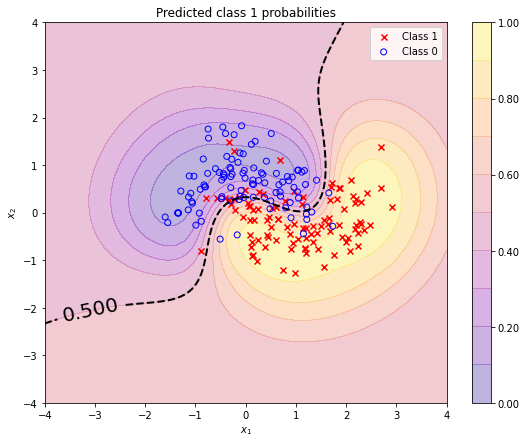

In [45]:
pt_test = predict_pt(grid.reshape(-1, 2), X, t, theta).reshape(*grid_x.shape)

plt.figure(figsize=(9, 7))
plot_pt_2D(grid_x, grid_y, pt_test)
plot_db_2D(grid_x, grid_y, pt_test, decision_boundary=0.5)
plot_data_2D(X, t)
plt.title('Predicted class 1 probabilities')
plt.legend();

Reference: 
1. [Gaussian processes for classification](https://krasserm.github.io/2020/11/04/gaussian-processes-classification/)
2. [Probabilistic predictions with Gaussian process classification](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc.html)